In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
from pprint import pprint

BATCH_SIZE = 2
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"

class_map = {
    0: "box",
    1: "green_light",
    2: "left_arrow",
    3: "no_light",
    4: "person",
    5: "red_light",
    6: "right_arrow",
    7: "tree",
    8: "unknown_arrow",
}

2024-05-01 11:25:05.793981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 11:25:05.794033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 11:25:05.794777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 11:25:05.800469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/home/dino/miniconda3/envs/picar-old/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True,
)

2024-05-01 11:25:07.703863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:07.708139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:07.708430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:07.710589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:07.710859: I external/local_xla/xla/stream_executor

In [13]:
model = keras.models.load_model(
    "object_detection_yolo/yolov8_small_1714298957.keras",
    custom_objects={"YOLOV8Detector": keras_cv.models.YOLOV8Detector},
)

/home/dino/miniconda3/envs/picar-old/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/dino/miniconda3/envs/picar-old/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [14]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,  # Minimum IOU for two boxes to be considered the same
    confidence_threshold=0.501,  # Minimum confidence for a box to be considered a detection
    max_detections=8,  # Maximum number of detections to keep
)

In [ ]:
# TODO: Hand-make a PiecewiseConstantDecay schedule
base_lr = 0.005
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
model.compile(
    classification_loss="binary_crossentropy", box_loss="ciou", optimizer=optimizer
)

In [ ]:
print(model.summary())

Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, None,     │  5,089,760 │ input_layer_1[0]… │
│ (Functional)        │ None, 128),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 512)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, None,      │          0 │ functional_1[0][… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_1 (Repeat)   │ (None, None,      │          0 │ repeat[0][0]      │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None,      │          0 │ repeat_1[0][0],   │
│ (Concatenate)       │ None, 768)        │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_co… │ (None, None,      │    196,608 │ concatenate_5[0]… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_bn  │ (None, None,      │      1,024 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre     │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_4 (Split)     │ [(None, None,     │          0 │ pa_fpn_p4p5_pre[… │
│                     │ None, 128),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 128)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ split_4[0][1]     │
│ (ZeroPadding2D)     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    147,456 │ pa_fpn_p4p5_pre_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │        512 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_1 │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (ZeroPadding2D)     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    147,456 │ pa_fpn_p4p5_pre_

 Total params: 13,211,707 (50.40 MB)

 Trainable params: 13,189,371 (50.31 MB)

 Non-trainable params: 22,336 (87.25 KB)

None


In [ ]:
# Make layer names unique
# for i, layer in enumerate(model.layers):
#     layer.name = f"{layer.name}_{i}"

# Same for weights
for i, layer in enumerate(model.layers):
    if hasattr(layer, "weights"):
        for j, weight in enumerate(layer.weights):
            weight.name = f"{weight.name}_{i}_{j}"

In [ ]:
# Find duplicate layer names
layer_names = set()
for layer in model.layers:
    if layer.name in layer_names:
        print(f"Duplicate layer name: {layer.name}")
    layer_names.add(layer.name)

# Find duplicate weight names
weight_names = set()
for weight in model.weights:
    if weight.name in weight_names:
        print(f"Duplicate weight name: {weight.name}")
    weight_names.add(weight.name)

# Find duplicate input names
input_names = set()
for input in model.inputs:
    if input.name in input_names:
        print(f"Duplicate input name: {input.name}")
    input_names.add(input.name)

# Find duplicate output names
output_names = set()
for output in model.outputs:
    if output.name in output_names:
        print(f"Duplicate output name: {output.name}")
    output_names.add(output.name)


# Find duplicate variable names
variable_names = set()
for variable in model.variables:
    if variable.name in variable_names:
        print(f"Duplicate variable name: {variable.name}")
    variable_names.add(variable.name)

In [ ]:
print(model.summary())

NameError: name 'model' is not defined

In [ ]:
model.save("h5/yolov8_small_1714298957.h5")

In [ ]:
# Convert the model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open("od_model.tflite", "wb") as f:
    f.write(tflite_model)

NameError: name 'model' is not defined

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="od_model.tflite")

=== od_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the MUL op takes
tensor #0 and tensor #155 as input and produces tensor #158 as output.

Subgraph#0 main(T#0) -> [T#502, T#501]
  Op#0 MUL(T#0, T#155) -> [T#158]
  Op#1 PAD(T#158, T#154[0, 0, 1, 1, 1, ...]) -> [T#159]
  Op#2 CONV_2D(T#159, T#70, T#1) -> [T#160]
  Op#3 LOGISTIC(T#160) -> [T#161]
  Op#4 MUL(T#160, T#161) -> [T#162]
  Op#5 PAD(T#162, T#154[0, 0, 1, 1, 1, ...]) -> [T#163]
  Op#6 CONV_2D(T#163, T#71, T#2) -> [T#164]
  Op#7 LOGISTIC(T#164) -> [T#165]
  Op#8 MUL(T#164, T#165) -> [T#166]
  Op#9 CONV_2D(T#166, T#72, T#3) -> [T#167]
  Op#10 LOGISTIC(T#167) -> [T#168]
  Op#11 MUL(T#167, T#168) -> [T#169]
  Op#12 SPLIT(T#153[-1], T#169) -> [T#170, T#171]
  Op#13 PAD(T#171, T#154[0, 0, 1, 1, 1, ...]) -> [T#172]
  Op#14 CONV_2D(T#172, T#73, T#4) -> [T#173]
  Op#15 LOGISTIC(T#173) -> [T#174]
  Op#16 MUL(T#173, T#174) -> [T#17

In [3]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="od_model.tflite")
# interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

interpreter.resize_tensor_input(input_details[0]["index"], (1, *IMAGE_SIZE, 3))

interpreter.allocate_tensors()

Input details: [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:1', 'index': 502, 'shape': array([1, 1, 9], dtype=int32), 'shape_signature': array([-1, -1,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 501, 'shape': array([ 1,  1, 64], dtype=int32), 'shape_signature': array([-1, -1, 64], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {

INFO: Created TensorFlow Lite delegate for select TF ops.
2024-05-01 11:25:13.169138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:13.169496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:13.169762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 11:25:13.170156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01

In [4]:
signatures = interpreter.get_signature_list()
print("signatures", signatures)

signatures {'serving_default': {'inputs': ['input_2'], 'outputs': ['box', 'class']}}


In [4]:
# Read and preprocess an image
image = tf.io.read_file("label_data/test/downloads_images/1709570998863_90_35.png")
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.float32)
image = np.array(image)
image = validation_resizing([image])


print(image.shape)

2024-05-01 11:25:16.530184: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1, 256, 384, 3)


In [ ]:
print("Input details:", input_details)
pprint(output_details)

Input details: [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'dtype': <class 'numpy.float32'>,
  'index': 502,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
                              'scales': array([], dtype=float32),
                              'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 9], dtype=int32),
  'shape_signature': array([-1, -1,  9], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': <class 'numpy.float32'>,
  'index': 501,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   

<class 'numpy.ndarray'>
{'boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[225.38756 ,  42.364574,  50.673172,  56.76653 ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      

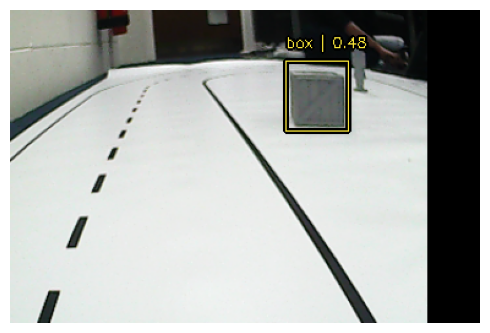

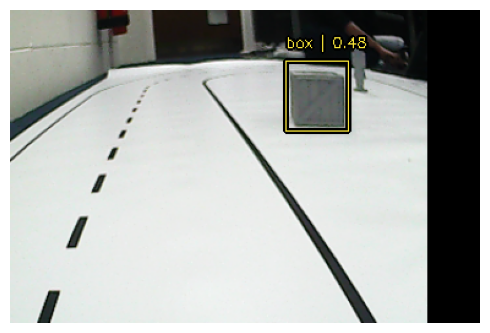

In [6]:
interpreter.set_tensor(input_details[0]["index"], image)
interpreter.invoke()

y_pred = {
    "classes": interpreter.get_tensor(output_details[0]["index"]),
    "boxes": interpreter.get_tensor(output_details[1]["index"]),
}


# y_pred2 = model.call(image)

print(type(y_pred["boxes"]))

yolomodel = keras_cv.models.YOLOV8Detector(
    num_classes=9,
    bounding_box_format=BBOX_FORMAT,
    fpn_depth=2,
    backbone=keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone"),
)


y_pred_decoded = yolomodel.decode_predictions(y_pred, image)

print(y_pred_decoded)


# pprint(y_pred)

# y_pred_print = y_pred.copy()
# y_pred_print["classes"] = [class_map[i] for i in y_pred["classes"].flatten() if i != -1]
# pprint(y_pred_print)
# """Format:
# {'boxes': [[x_left, y_top, width, height], ...],
#  'classes': [class_id, ...],
#  'confidence': [confidence, ...]
#  'num_detections': [int]}
# """

keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred_decoded,
    scale=5,
    font_scale=0.4,
    line_thickness=1,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_map,
)